In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Dataset

In [2]:
data = pd.read_csv("data/account_scoring_data.csv")

In [6]:
data.head()

,id,mql_date,region,billing_country,city,gtm_segment__c,abm_group__c,industry,icp_tier,persona__c,...,hiring,new_manager,annualrevenue,has_at_least_one_non_company_email,has_atl_contact,num_of_atl_contacts,has_btl_contact,num_of_btl_contacts,num_contacts,sql
0,0016100000WjpgrAAB,2019-09-25 00:00:00,Northern America,US,major_city,Small Business,Inbound,Internet Software & Services,Tier 2,NaN,...,0,0,1.000000e+07,1,0,0,1,5,26,0
1,0016100000WjoJdAAJ,2019-10-11 00:00:00,Northern America,US,Other,Midsized Companies,Inbound,Diversified Consumer Services,Tier 1,NaN,...,0,0,1.000000e+07,1,0,0,1,15,59,0
2,0016100000WjovfAAB,2019-07-23 00:00:00,Northern America,CA,Other,Enterprise,MoFu,Diversified Consumer Services,Tier 1,Small Company,...,0,0,1.000000e+09,0,0,0,1,6,11,0
3,0014M00001jpgMnQAI,2019-09-06 00:00:00,Northern America,US,Other,Enterprise,MoFu,Automotive,Other,NaN,...,0,0,1.000000e+08,0,0,0,0,0,7,0
4,0016100000WjoEaAAJ,2019-04-03 00:00:00,Australia and New Zealand,NZ,Other,Small Business,Inbound,Internet Software & Services,Tier 2,NaN,...,0,0,NaN,1,0,0,1,5,32,0


## Drop irrelevant columns & Encode categorical features

In [7]:
# Drop the "id", "mql_date" columns
df_mod = data.drop(columns=(["id","mql_date"]),axis = 1)
print(df_mod.shape)
df_mod['annualrevenue'] = df_mod['annualrevenue'].astype(float)

# Encode categorical features
categorical_features = list(df_mod.select_dtypes(include=object).columns)
df_enc = pd.get_dummies(df_mod, columns = categorical_features)
print(df_enc.shape)

df_enc = df_enc.dropna().drop_duplicates()

# Replace special characters in df_enc
df_enc.columns = df_enc.columns.str.replace('[^A-Za-z0-9]+', '_')

(44702, 25)
(44702, 584)


## Split the dataset in Train & Test

In [8]:
# Split in train and test
from sklearn.model_selection import train_test_split
y = df_enc['sql']
X = df_enc

X_train, X_test_unk, y_train, y_test_unk = train_test_split(X.drop('sql', axis=1), y,
                                                            test_size=0.2, random_state=27,
                                                            stratify = y)

## Undersample Train dataset

In [9]:
# Create Train dataset by Concatenating [X_train, y_train]
df_train = pd.concat([X_train, y_train], axis = 1)
# Random shuffle
df_train = df_train.sample(frac=1)

sqls = df_train.sql.sum()

# Undersampling
sql_df = df_train.loc[df_train["sql"] == 1]
non_sql_df = df_train.loc[df_train["sql"] == 0][:10*sqls]

# Concat to create dataset
normal_distributed_df = pd.concat([sql_df, non_sql_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)


X_train, X_test_val, y_train, y_test_val = train_test_split(new_df.drop('sql', axis=1),
                                                            new_df.sql, 
                                                            test_size=0.2, 
                                                            random_state=27, 
                                                            stratify = new_df.sql)

## LightGBM

In [13]:
# LightGBM
import lightgbm
train_set = lightgbm.Dataset(X_train, label=y_train, params={'verbose': -1})

train_params = {
    'objective': 'binary',
    'num_leaves': 100,
    'random_seed': 3333,
    'learning_rate': 0.005,
    'boosting_type': 'gbdt',
    'verbose': -1
}

from lightgbm import LGBMClassifier
clf = LGBMClassifier(**train_params)
clf.fit(X_train, y_train.values.ravel())


import sklearn.metrics
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test_val, clf.predict_proba(X_test_val)[:,1])
y_pred = clf.predict_proba(X_test_val)[:,1]
y_pred_binary = [1 if y>0.1 else 0 for y in y_pred]
print("AUC:", sklearn.metrics.auc(fpr, tpr))
print("F1 Score:", sklearn.metrics.f1_score(y_test_val, y_pred_binary))
print("Confusion Matrix:", sklearn.metrics.confusion_matrix(y_test_val, y_pred_binary))

AUC: 0.8109321343344393
F1 Score: 0.3815384615384615
Confusion Matrix: [[648 180]
 [ 21  62]]


### Feature importance

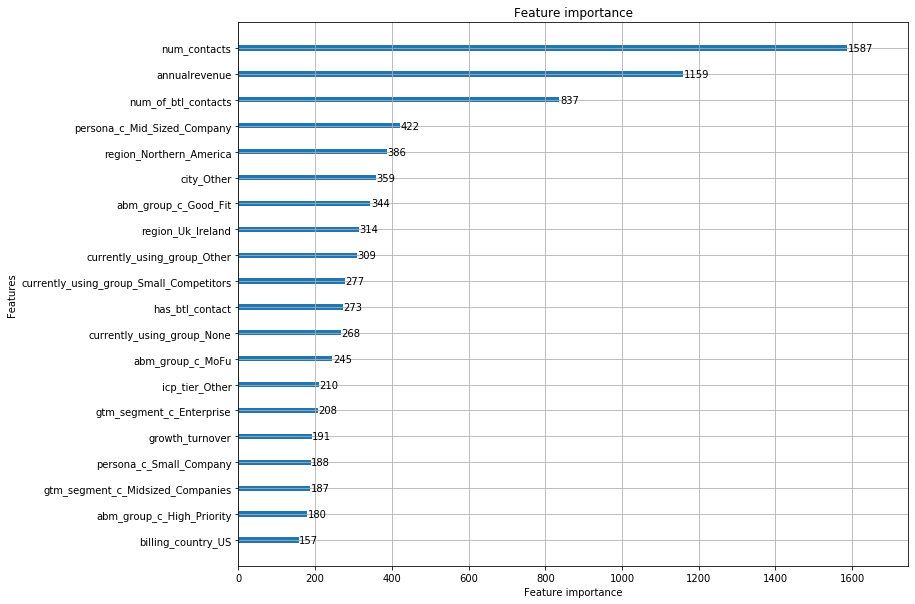

In [14]:
lightgbm.plot_importance(
   clf,
   figsize=(12, 10),
   max_num_features=20
);

### Test in the unknown dataset

In [16]:
import sklearn.metrics
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test_unk, clf.predict_proba(X_test_unk)[:,1])
y_pred = clf.predict_proba(X_test_unk)[:,1]
y_pred_binary = [1 if y>0.1 else 0 for y in y_pred]
print("AUC:", sklearn.metrics.auc(fpr, tpr))
print("F1 Score:", sklearn.metrics.f1_score(y_test_unk, y_pred_binary))
print("Confusion Matrix:", sklearn.metrics.confusion_matrix(y_test_unk, y_pred_binary))

AUC: 0.8285058660400068
F1 Score: 0.08351409978308025
Confusion Matrix: [[5975 1664]
 [  26   77]]


### Cross-validation

In [17]:
train_params = {
    'objective': 'binary',
    'num_leaves': 1000,
    'random_seed': 3333,
    'learning_rate': 0.02,
    'verbose': -1
}


# Cross-validation
N_FOLDS = 10
MAX_BOOST_ROUNDS = 700
train_params = {
    'objective': 'binary',
    'num_leaves': 1000,
    'random_seed': 3333,
    'verbose': -1,
    'learning_rate': 0.02,
}
d_train = lightgbm.Dataset(X_train, label=y_train, params={'verbose': -1})

cv_results = lightgbm.cv(train_params, d_train, num_boost_round=MAX_BOOST_ROUNDS, nfold=N_FOLDS, 
                    verbose_eval=20, early_stopping_rounds=40, metrics=['auc'],
                        stratified=True)

print('Current parameters:\n', train_params)
# print('\nBest num_boost_round:', len(cv_results['auc-mean']))
print('Best CV-AUC score:', cv_results['auc-mean'][-1])
# print('Best CV-AUC score:', cv_results['accuracy-mean'][-1])

[20]	cv_agg's auc: 0.795374 + 0.038447
[40]	cv_agg's auc: 0.789275 + 0.0328279
[60]	cv_agg's auc: 0.793959 + 0.0365351
Current parameters:
 {'objective': 'binary', 'num_leaves': 1000, 'random_seed': 3333, 'verbose': -1, 'learning_rate': 0.02}
Best CV-AUC score: 0.7961185088026468


### Grid Search

In [149]:
from sklearn.model_selection import GridSearchCV
gridParams = {
    'learning_rate': [0.005, 0.01, 0.02, 0.05, 0.1],
    'n_estimators': range(100, 1000, 100),
    'num_leaves': [8, 16, 20, 24, 28, 32],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [3333],
}

clf = LGBMClassifier()
# Create the grid
grid = GridSearchCV(clf, gridParams,
                    verbose=3,
                    cv=5,
                    n_jobs=-1,
                    scoring='roc_auc'
                    )
# Run the grid
grid.fit(X, y)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

clf = LGBMClassifier(**grid.best_params_)
clf.fit(X_train, y_train)


fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test_val, clf.predict_proba(X_test_val)[:,1])
print('[BestParams]-AUC Score on test: {}'.format(sklearn.metrics.auc(fpr, tpr)))

# #current['prediction'] = clf.predict(current)
# fpr, tpr, thresholds = sklearn.metrics.roc_curve(target_current, clf.predict(current))
# print('[BestParams]-AUC Score on test: {}'.format(sklearn.metrics.auc(fpr, tpr)))

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed: 15.9min finished


{'boosting_type': 'gbdt', 'learning_rate': 0.005, 'n_estimators': 100, 'num_leaves': 8, 'objective': 'binary', 'random_state': 3333}
1.0
[BestParams]-AUC Score on test: 0.8478907222914073
